<a href="https://colab.research.google.com/github/1wanz/course-v3/blob/master/Warcolorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 46.5MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
#drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
path = Path('gdrive/My Drive/fastai-v3/data/WorldWar2')
path_hr = path/'images'
path_lr = path/'decolorize'

In [ ]:
dest = path
file = 'WW2.csv'

download_images(dest/file, dest, max_pics=1000)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

In [ ]:
from PIL import Image, ImageDraw, ImageFont

class decolorizer(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn).convert("L")
        img.save(dest)

In [ ]:
il = ImageList.from_folder(path_hr)
parallel(decolorizer(path_lr, path_hr), il.items)

In [ ]:
bs,size=32, 128
arch = models.resnet34

Pre-train generator

In [ ]:
arch = models.resnet34
# sample = 0.1
sample = False

tfms = get_transforms()

In [ ]:
src = ImageImageList.from_folder(path_lr)

In [ ]:
if sample: src = src.filter_by_rand(sample, seed=42)

In [ ]:
src = src.split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [ ]:
data_gen = get_data(bs,size)

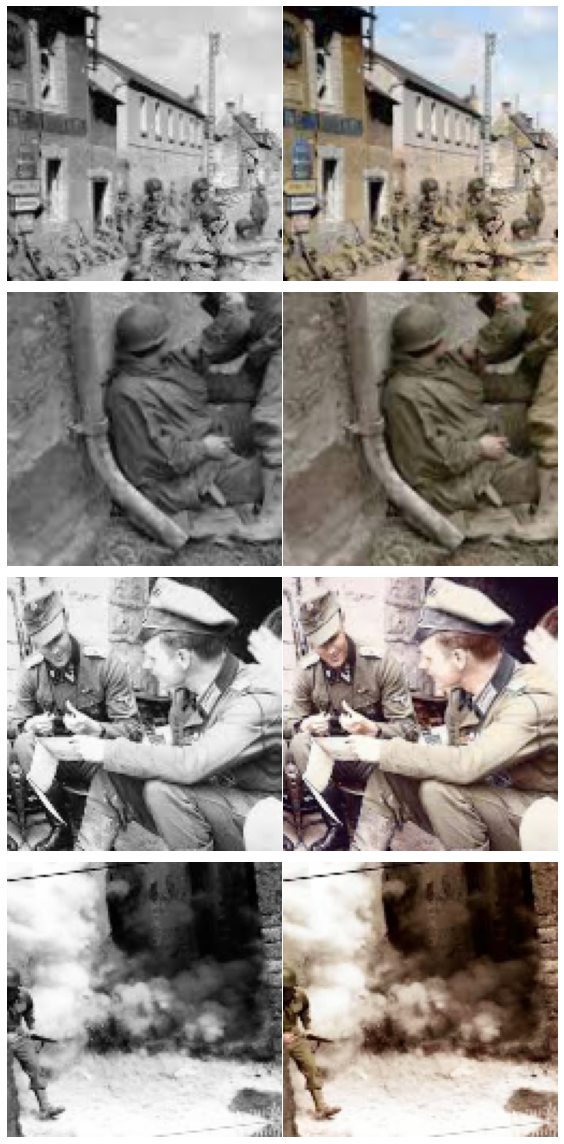

In [ ]:
data_gen.show_batch(4)

In [ ]:
wd = 1e-3

In [ ]:
y_range = (-3.,3.)

In [ ]:
loss_gen = MSELossFlat()

In [ ]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [ ]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

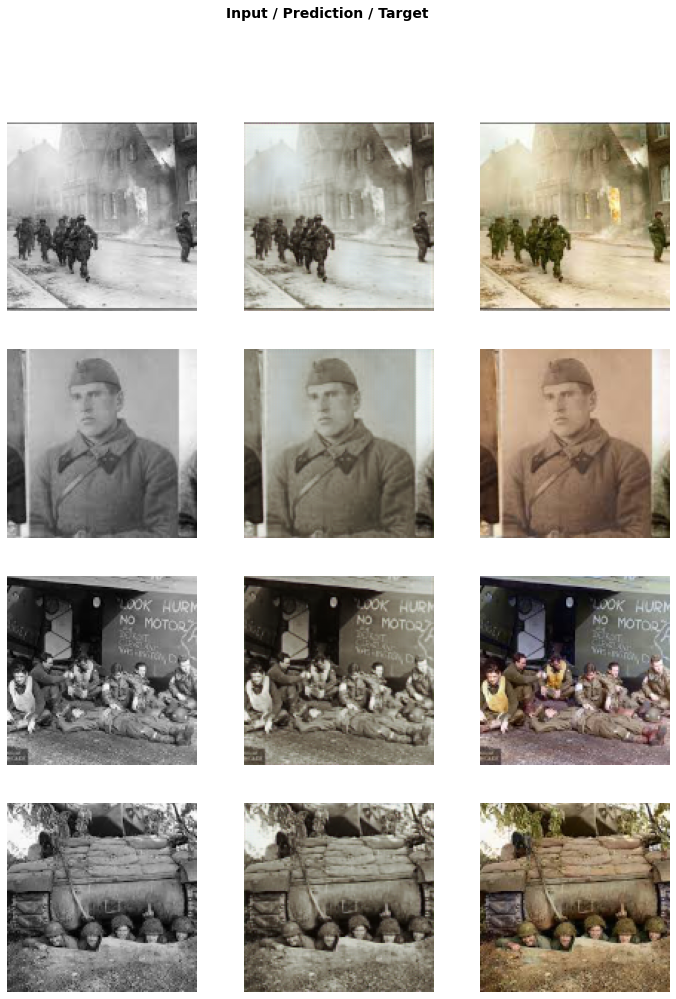

In [ ]:
learn_gen.show_results(rows=4)

In [ ]:
learn_gen.save('gen-pre2')

Save generated images

In [ ]:
learn_gen.load('gen-pre2');

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [ ]:
save_preds(data_gen.fix_dl)

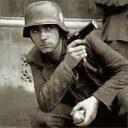

In [ ]:
PIL.Image.open(path_gen.ls()[0])

Train critic

In [ ]:
learn_gen=None
gc.collect()

22

In [ ]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [ ]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
WorldWar2
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
WorldWar2
  if getattr(ds, 'warn', False): warn(ds.warn)


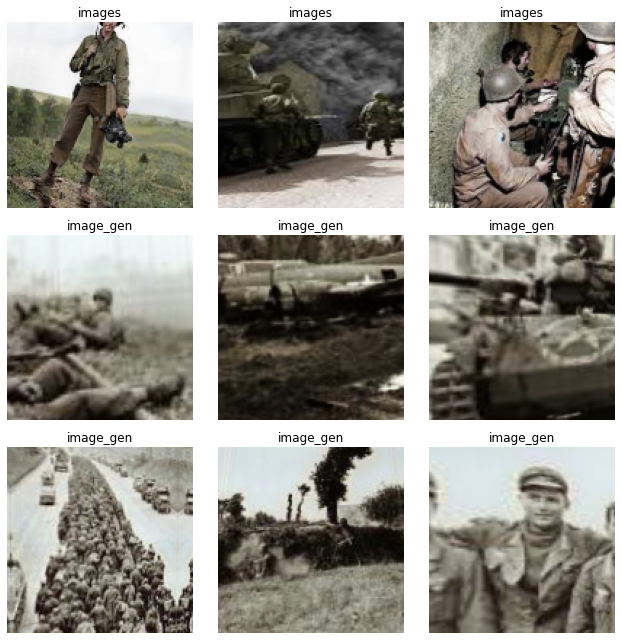

In [ ]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [ ]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3)

In [ ]:
learn_critic.save('critic-pre2')

GAN

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

19442

In [ ]:
data_crit = get_crit_data(['decolorize', 'images'], bs=bs, size=size)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
WorldWar2
  if getattr(ds, 'warn', False): warn(ds.warn)
/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
WorldWar2
  if getattr(ds, 'warn', False): warn(ds.warn)


In [ ]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(5,lr)

In [ ]:
learn.save('gan-1c')

In [ ]:
learn.data=get_data(16,192)

In [ ]:
learn.fit(10,lr/2)

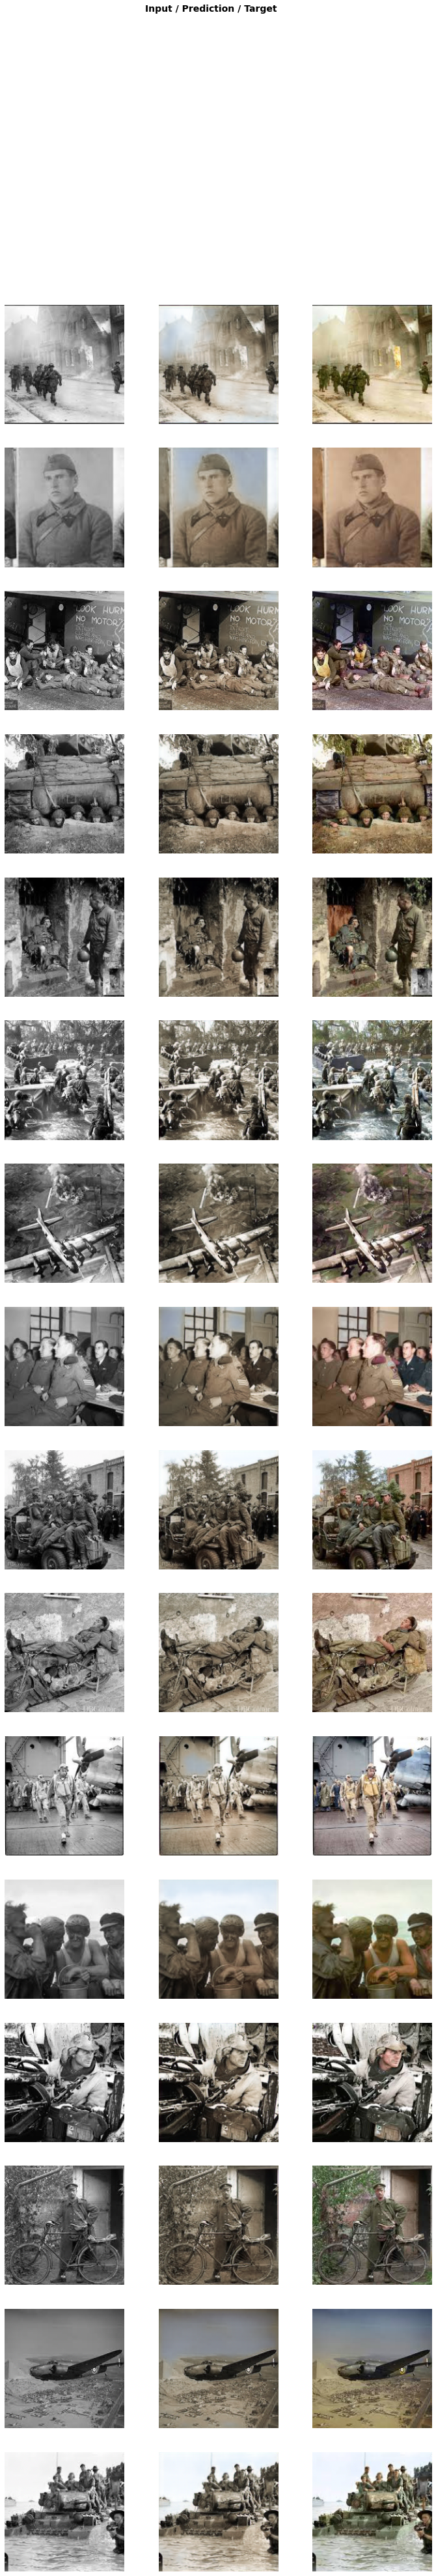

In [ ]:
learn.show_results(rows=16)

In [ ]:
learn.save('gan-1c')

Test